<a href="https://colab.research.google.com/github/MADHAVAHARSHA/Affectnet-using-FER/blob/main/Affectnet_facial_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Connecting to google drive and download the data

In [ ]:
import gdown
file_id = '1Qu_-IbuURRzII1S4i4qiZ10d8NuR0kCf'
output = 'fer.zip'  # Specify the desired output file name and extension.  https://drive.google.com/file/d/1-ljzMpElKBeXMbslwRr5iGOahp9SAmtR/view?usp=share_link
gdown.download(f'https://drive.google.com/uc?id={file_id}', output)

Downloading...
From: https://drive.google.com/uc?id=1Qu_-IbuURRzII1S4i4qiZ10d8NuR0kCf
To: /content/fer.zip
100%|██████████| 341M/341M [00:07<00:00, 45.0MB/s]


'fer.zip'

In [ ]:
# https://drive.google.com/file/d/1GiotOkAD80bo6ephXuZJybl_xlvE_zFJ/view?usp=sharing
#https://drive.google.com/file/d/1Qu_-IbuURRzII1S4i4qiZ10d8NuR0kCf/view?usp=sharing

In [ ]:
import zipfile

# Specify the path to the downloaded zip file
zip_path = '/content/fer.zip'

# Specify the destination folder where you want to extract the contents
destination_folder = '/content/fer'

# Open the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract all contents to the destination folder
    zip_ref.extractall(destination_folder)

print("File successfully unzipped.")

File successfully unzipped.


* New Method


In [ ]:
import os
import cv2
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import numpy as np

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path to the original training folder
original_folder = '/content/fer/affectnet'

# Path to the new training and validation folders
new_training_folder = '/content/train80'
new_validation_folder = '/content/val20'

# Define the ratio for splitting (e.g., 80% for training, 20% for validation)
train_ratio = 0.8

# Iterate through the original folder and its subdirectories
for root, dirs, files in os.walk(original_folder):
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        new_train_dir = os.path.join(new_training_folder, dir_path[len(original_folder)+1:])
        new_val_dir = os.path.join(new_validation_folder, dir_path[len(original_folder)+1:])

        os.makedirs(new_train_dir, exist_ok=True)
        os.makedirs(new_val_dir, exist_ok=True)

        # Split images within the current subdirectory
        all_files = os.listdir(dir_path)
        train_files, val_files = train_test_split(all_files, train_size=train_ratio, random_state=42)

        for file in train_files:
            src = os.path.join(dir_path, file)
            dst = os.path.join(new_train_dir, file)
            shutil.copy(src, dst)

        for file in val_files:
            src = os.path.join(dir_path, file)
            dst = os.path.join(new_val_dir, file)
            shutil.copy(src, dst)


In [ ]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Set the batch size and image input dimensions
batch_size = 32
input_shape = (96, 96, 3)  # Change to grayscale (1 channel)

# Flow training images from the preprocessed training folder
train_generator = train_datagen.flow_from_directory(
    new_training_folder,
    target_size=input_shape[:2],
    batch_size=batch_size,
    color_mode='rgb',  # Change to grayscale
    class_mode='categorical',
    shuffle=True
)

# Flow validation images from the preprocessed testing folder
validation_generator = test_datagen.flow_from_directory(
    new_validation_folder,
    target_size=input_shape[:2],
    batch_size=batch_size,
    color_mode='rgb',  # Change to grayscale
    class_mode='categorical',
    shuffle=False
)

Found 23229 images belonging to 8 classes.
Found 5813 images belonging to 8 classes.


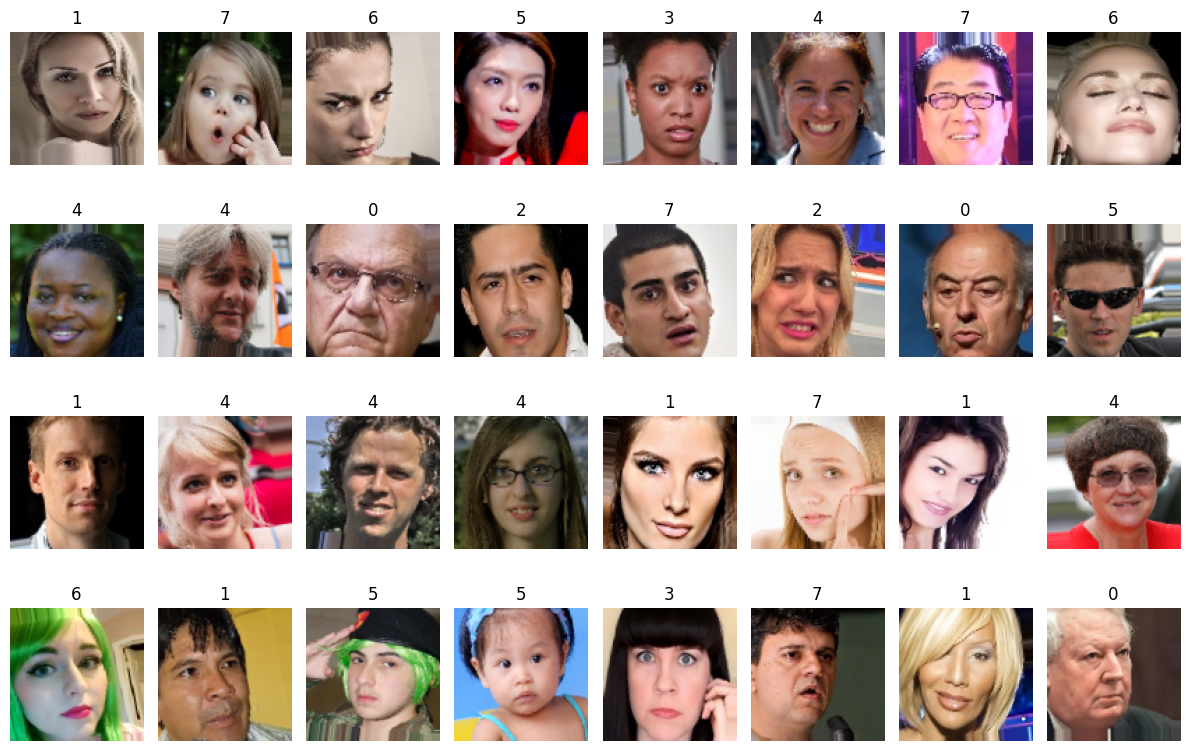

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of images and labels from train_generator
x_batch, y_batch = next(train_generator)

# Print the images and labels for train_generator
fig, axes = plt.subplots(4, 8, figsize=(12, 8))
axes = axes.ravel()
for i in range(32):
    axes[i].imshow(np.squeeze(x_batch[i]), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(np.argmax(y_batch[i]))
plt.tight_layout()
plt.show()



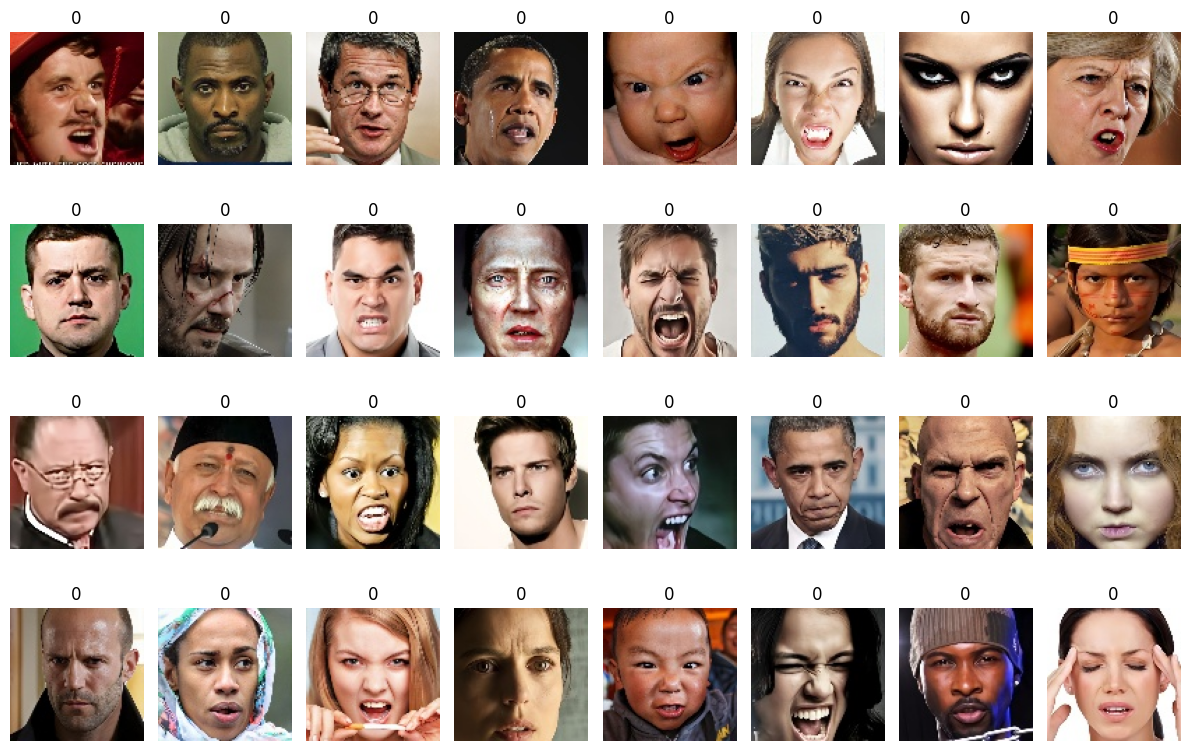

In [ ]:
# Get a batch of images and labels from validation_generator
x_batch, y_batch = next(validation_generator)

# Print the images and labels for validation_generator
fig, axes = plt.subplots(4, 8, figsize=(12, 8))
axes = axes.ravel()
for i in range(32):
    axes[i].imshow(np.squeeze(x_batch[i]), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(np.argmax(y_batch[i]))
plt.tight_layout()
plt.show()


In [ ]:
num_classes = 8
img_rows, img_cols = 96, 96

model = Sequential()

# Block-1
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', input_shape=(img_rows, img_cols, 3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block-2
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block-3
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block-4
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block-5
model.add(Flatten())
model.add(Dense(64, kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block-6
model.add(Dense(64, kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block-7
model.add(Dense(num_classes, kernel_initializer='he_normal'))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 96, 96, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                        

In [ ]:

import numpy as np
from sklearn.utils import compute_class_weight

# Get the true class labels from the generator
train_labels = train_generator.classes

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = dict(zip(np.unique(train_labels), class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 1.1280594405594406, 1: 1.2646450348432057, 2: 1.4657370015143867, 3: 1.1431594488188976, 4: 0.7196096654275093, 5: 0.7082012195121952, 6: 1.1746055825242718, 7: 0.8986768802228412}


In [ ]:
# from keras import backend as K
# def weighted_categorical_crossentropy(weights):
#     """
#     A weighted version of keras.objectives.categorical_crossentropy

#     Variables:
#         weights: numpy array of shape (C,) where C is the number of classes

#     Usage:
#         weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
#         loss = weighted_categorical_crossentropy(weights)
#         model.compile(loss=loss,optimizer='adam')
#     """

#     weights = K.variable(weights)

#     def loss(y_true, y_pred):
#         # scale predictions so that the class probas of each sample sum to 1
#         y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
#         # clip to prevent NaN's and Inf's
#         y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
#         # calc
#         loss = y_true * K.log(y_pred) * weights
#         loss = -K.sum(loss, -1)
#         return loss

#     return loss

In [ ]:
# # Define the class weights (adjust these values accordingly)
# class_weights = np.array([  0.9912646149711061,  9.083743842364532,  1.0874244434615952, 0.5478583807873236,  0.7960571284671007,  0.9270213657310431,  1.2479837572612937])  # Example weights for three classes

# # Create the weighted loss function
# weighted_loss = weighted_categorical_crossentropy(class_weights)


weighted_categorical_crossentropy

In [ ]:
# from keras.callbacks import ModelCheckpoint, EarlyStopping

# # ... (previous code for model creation and compilation)

# # Define early stopping callback
# early_stopping = EarlyStopping(
#     monitor='val_loss',  # Monitor validation loss
#     patience=5,  # Number of epochs with no improvement before stopping
#     verbose=1,  # Print messages about early stopping
#     restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
# )

In [ ]:
checkpoint = ModelCheckpoint('affectnet.h5',
                             monitor='val_loss',
                             mode='auto',
                             save_best_only=True,
                             verbose=0)

callbacks = [checkpoint]

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

epochs = 30

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    class_weight=class_weights
)


<ipython-input-14-d2b8ed202ce7>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
725/725 [==============================] - 108s 122ms/step - loss: 2.3991 - accuracy: 0.1695 - val_loss: 1.7901 - val_accuracy: 0.2894
Epoch 2/30
725/725 [==============================] - 86s 119ms/step - loss: 1.8679 - accuracy: 0.2790 - val_loss: 1.6060 - val_accuracy: 0.3679
Epoch 3/30
725/725 [==============================] - 85s 117ms/step - loss: 1.6140 - accuracy: 0.4024 - val_loss: 1.3357 - val_accuracy: 0.4743
Epoch 4/30
725/725 [==============================] - 85s 117ms/step - loss: 1.4341 - accuracy: 0.4794 - val_loss: 1.1374 - val_accuracy: 0.5483
Epoch 5/30
725/725 [==============================] - 83s 114ms/step - loss: 1.3502 - accuracy: 0.5122 - val_loss: 1.1548 - val_accuracy: 0.5404
Epoch 6/30
725/725 [==============================] - 83s 114ms/step - loss: 1.2912 - accuracy: 0.5351 - val_loss: 1.0826 - val_accuracy: 0.5649
Epoch 7/30
725/725 [==============================] - 82s 114ms/step - loss: 1.2524 - accuracy: 0.5592 - val_loss: 1.0655 - val_a

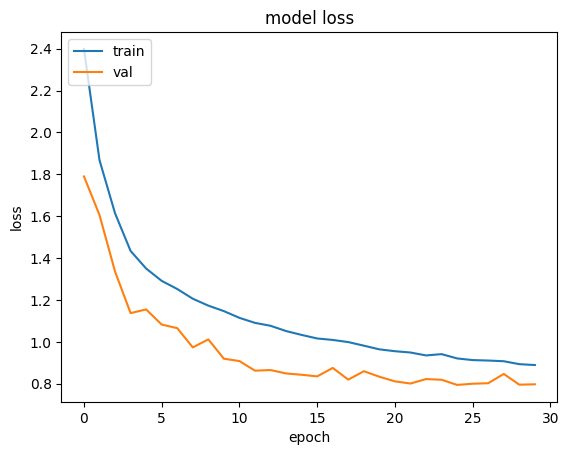

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

 49/182 [=======>......................] - ETA: 3s - loss: 1.1244 - accuracy: 0.5963

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate predictions for the test data
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = ['Angry', 'contempt','Disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mat, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Fill the matrix with values and labels
thresh = confusion_mat.max() / 2.0
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        plt.text(j, i, format(confusion_mat[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mat[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


182/182 [==============================] - 6s 34ms/step


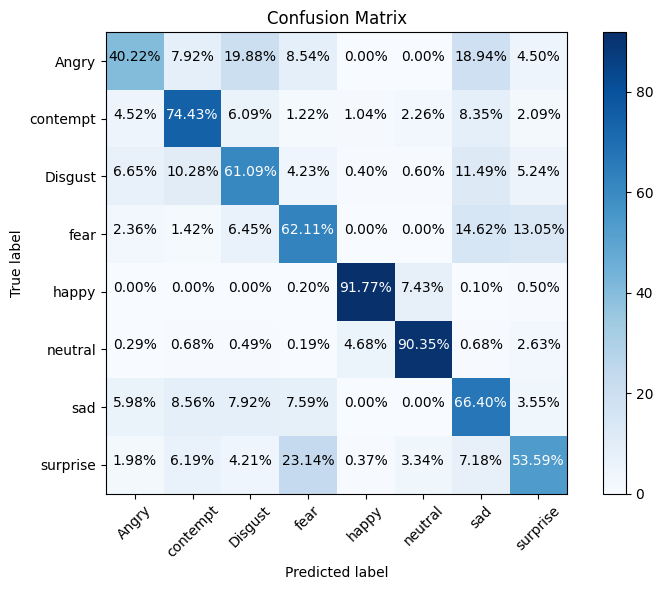

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate predictions for the test data
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# Calculate the percentage values in the confusion matrix
confusion_mat_percentage = confusion_mat / confusion_mat.sum(axis=1)[:, np.newaxis] * 100

# Define class labels
class_labels = ['Angry', 'contempt','Disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mat_percentage, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Fill the matrix with percentage values and labels
thresh = confusion_mat_percentage.max() / 2.0
for i in range(confusion_mat_percentage.shape[0]):
    for j in range(confusion_mat_percentage.shape[1]):
        plt.text(j, i, format(confusion_mat_percentage[i, j], '.2f') + '%',
                 horizontalalignment="center",
                 color="white" if confusion_mat_percentage[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


* Test Time Agumentation

In [ ]:
# Define augmented parameters for TTA
tta_datagen = ImageDataGenerator(
     rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Flow test images from the preprocessed test folder with TTA
tta_generator = tta_datagen.flow_from_directory(
    preprocessed_test_folder,
    target_size=input_shape[:2],
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

num_augmentations = 15

# Initialize an array to store predictions for TTA
test_predictions_sum = np.zeros((tta_generator.samples, num_classes))

# Generate predictions using TTA for test data
for _ in range(num_augmentations):
    test_predictions = model.predict_generator(
        tta_generator,
        steps=tta_generator.samples // tta_generator.batch_size,
        verbose=1
    )
    test_predictions_sum[:test_predictions.shape[0]] += test_predictions

# Average the predictions for test data
test_predictions_avg = test_predictions_sum / num_augmentations

# Convert the predicted probabilities to class labels for test data
test_predicted_labels = np.argmax(test_predictions_avg, axis=1)

# ... (calculate and print test accuracy and other evaluations if needed)
# ... (calculate and print test accuracy and other evaluations if needed)
from sklearn.metrics import classification_report, confusion_matrix

# Calculate and print test accuracy
test_accuracy = np.mean(test_predicted_labels == tta_generator.classes)
print("Test Accuracy (with TTA): {:.2f}%".format(test_accuracy * 100))

# # Calculate and print classification report
# class_names = list(tta_generator.class_indices.keys())
# print("Classification Report:\n")
# print(classification_report(tta_generator.classes, test_predicted_labels, target_names=class_names))

# Calculate and print confusion matrix
confusion = confusion_matrix(tta_generator.classes, test_predicted_labels)
print("Confusion Matrix:\n")
print(confusion)


Found 6925 images belonging to 7 classes.
  1/216 [..............................] - ETA: 15s

<ipython-input-68-b6baa2b810c2>:40: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predictions = model.predict_generator(


216/216 [==============================] - 9s 43ms/step
Test Accuracy (with TTA): 65.83%
Confusion Matrix:

[[ 536   54   90   20  129   93   35]
 [  15   85    2    3    3    1    2]
 [ 102   14  373   17  127  159  126]
 [  37    8   27 1469  128   34   70]
 [  54   12   53   58  898  124   34]
 [ 102   14  141   34  288  498   25]
 [  23    3   59   17   18   11  700]]


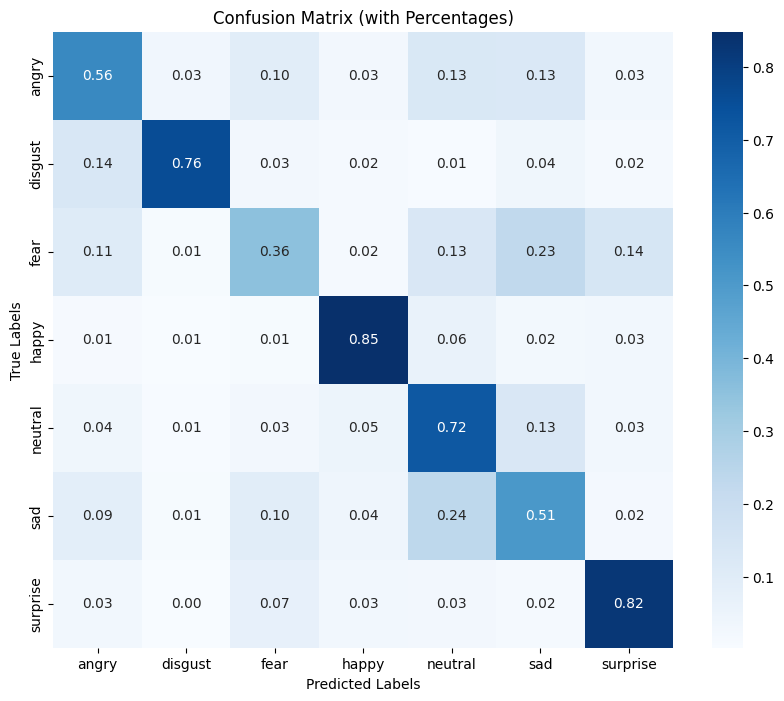

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# ... (previous code)

# Calculate the confusion matrix with percentages
confusion_percent = confusion / confusion.sum(axis=1, keepdims=True)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_percent,
    annot=True,
    fmt=".2f",  # Display percentages with two decimal places
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Confusion Matrix (with Percentages)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:

# # --- Implement Test Time Augmentation for preprocessed_test folder ---

# # Flow test images from the preprocessed test folder with TTA
# test_generator = test_datagen.flow_from_directory(
#     preprocessed_test_folder,
#     target_size=input_shape[:2],
#     batch_size=batch_size,
#     color_mode='rgb',
#     class_mode='categorical',
#     shuffle=False
# )
# num_augmentations = 10
# # Initialize an array to store predictions for TTA
# test_predictions_sum = np.zeros((test_generator.samples, num_classes))

# # Generate predictions using TTA for test data
# for _ in range(num_augmentations):
#     test_predictions = model.predict_generator(
#         test_generator,
#         steps=test_generator.samples // test_generator.batch_size,
#         verbose=1
#     )
#     test_predictions_sum[:test_predictions.shape[0]] += test_predictions

# # Average the predictions for test data
# test_predictions_avg = test_predictions_sum / num_augmentations

# # Convert the predicted probabilities to class labels for test data
# test_predicted_labels = np.argmax(test_predictions_avg, axis=1)

# # ... (calculate and print test accuracy and other evaluations if needed)
# from sklearn.metrics import classification_report, confusion_matrix

# # Calculate and print test accuracy
# test_accuracy = np.mean(test_predicted_labels == test_generator.classes)
# print("Test Accuracy (with TTA): {:.2f}%".format(test_accuracy * 100))

# # Calculate and print classification report
# class_names = list(test_generator.class_indices.keys())
# print("Classification Report:\n")
# print(classification_report(test_generator.classes, test_predicted_labels, target_names=class_names))

# # Calculate and print confusion matrix
# confusion = confusion_matrix(test_generator.classes, test_predicted_labels)
# print("Confusion Matrix:\n")
# print(confusion)


Found 6925 images belonging to 7 classes.
  5/216 [..............................] - ETA: 3s 

<ipython-input-61-d21090c5d3bd>:18: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predictions = model.predict_generator(


216/216 [==============================] - 3s 15ms/step
Test Accuracy (with TTA): 64.03%
Classification Report:

              precision    recall  f1-score   support

       angry       0.58      0.56      0.57       957
     disgust       0.46      0.74      0.56       111
        fear       0.47      0.42      0.44       918
       happy       0.91      0.80      0.85      1773
     neutral       0.53      0.73      0.62      1233
         sad       0.56      0.40      0.47      1102
    surprise       0.70      0.80      0.74       831

    accuracy                           0.64      6925
   macro avg       0.60      0.64      0.61      6925
weighted avg       0.65      0.64      0.64      6925

Confusion Matrix:

[[ 540   41   94   14  155   85   28]
 [  17   82    3    3    4    1    1]
 [ 117   15  388   17  140  126  115]
 [  60    8   43 1418  141   27   76]
 [  56   13   66   54  897  105   42]
 [ 110   17  150   30  323  444   28]
 [  34    4   86   14   20    8  665]]


* VGG16

In [ ]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
input_shape = (48, 48, 3)
optim_1 = Adam(learning_rate=0.01)
n_classes=7
BATCH_SIZE = 32

n_steps = train_generator.samples // BATCH_SIZE
n_val_steps = validation_generator.samples // BATCH_SIZE
n_epochs = 50

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

In [ ]:
pip install livelossplot

In [ ]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           mode='min')

In [ ]:
vgg_history = vgg_model.fit(train_generator,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validation_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1,
                            class_weight = class_weights)


* ResNet50


In [ ]:
import numpy as np
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

# Load your oversampled data and labels here
# X_train_oversampled, y_train_oversampled, X_val, y_val, class_names


# Step 2: Initialize and compile the ResNet-50V2 model
base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',  # You can use None or 'imagenet' depending on your preference
    input_shape=(48, 48, 3)  # Input shape for the FER2013 dataset
)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 50
import numpy as np
from sklearn.utils import compute_class_weight

# Get the true class labels from the generator
train_labels = train_generator.classes

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = dict(zip(np.unique(train_labels), class_weights))
print("Class Weights:", class_weights)
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=validation_generator,
    class_weight=class_weights
)


# history = model.fit_generator(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     epochs=epochs,
#     callbacks=[checkpoint],
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // validation_generator.batch_size,
#     #class_weight=class_weights
# )


Class Weights: {0: 0.9912646149711061, 1: 9.083743842364532, 2: 1.0874244434615952, 3: 0.5478583807873236, 4: 0.7960571284671007, 5: 0.9270213657310431, 6: 1.2479837572612937}
Epoch 1/50
692/692 [==============================] - 133s 93ms/step - loss: 1.9020 - accuracy: 0.2339 - val_loss: 3.9501 - val_accuracy: 0.1149
Epoch 2/50
692/692 [==============================] - 59s 85ms/step - loss: 1.8689 - accuracy: 0.2261 - val_loss: 2.4851 - val_accuracy: 0.2074
Epoch 3/50
692/692 [==============================] - 61s 87ms/step - loss: 1.8161 - accuracy: 0.2654 - val_loss: 6.5476 - val_accuracy: 0.1335
Epoch 4/50
692/692 [==============================] - 62s 89ms/step - loss: 1.7675 - accuracy: 0.2833 - val_loss: 1.6976 - val_accuracy: 0.3367
Epoch 5/50
692/692 [==============================] - 60s 87ms/step - loss: 1.7726 - accuracy: 0.2983 - val_loss: 1.7055 - val_accuracy: 0.3551
Epoch 6/50
692/692 [==============================] - 62s 90ms/step - loss: 1.7158 - accuracy: 0.3231 -

KeyboardInterrupt: ignored

In [ ]:
model.save("/content/resnet.h5")